In [1]:
import pandas as pd
import numpy as np
import torch
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt


from elo import update, initialize_elo, offdef_shift, pred_total

# Offensive and Defensive rating

## Background
Currently, we have an effective elo system. This allows us to predict the outcome of games as well as the point spread, but it doesn't help us predict the *total* score,  *_over/under_*. For this reason, I'd like to hold separate offensive ratings and defensive ratings for each team. These ratings will sum to the team's ELO, because the offense and defense together comprise most of the team. Of course, there are special teams units as well, but these typically have a minimal impact on the game.

To further understand the need for ORTG and DRTG, let's look at two hypothetical games. Suppose team A and team B have equal Elo ratings of 1500. In the first hypothetical game, the defenses dominate, and the final score is 3-0. In another hypothetical game, team A again wins by just 3 points, but the offenses had a lot more success: the final score is 33-30.

Below, we can see that our Elo system sees no difference between these two games, because it only cares about the _difference_ between the team's elo ratings and the _difference_ between the two scores.

In [2]:
A, B = 1500, 1500
print(update(A, B, 3, 0))
print(update(A, B, 33, 30))

(1513.862943611199, 1486.137056388801)
(1513.862943611199, 1486.137056388801)


# Let's get started!

## Naive approach
In order to obtain an "O-factor" between 0 and 1, we'll take the total score and divide it by the "highest possible score". Because there's obviously no highest possible score, we'll instead take a large score as a pseudo-maximum. If you score more than that, we'll assign the o-factor to 1.

In [3]:
df = pd.read_csv("./data/archive/spreadspoke_scores.csv")

## Preprocess

columns = ['schedule_date', 'team_home', 'team_away', 'score_home', 'score_away', 'over_under_line']
df = df[columns]

# Convert schedule to date format (so we can compare dates)
df['schedule_date'] = pd.to_datetime(df['schedule_date']).dt.date
# df = df[df['schedule_date'] > datetime.date(1999, 1, 1)]

# Remove team locations (New England Patriots -> Patriots)
df['team_home'] = df['team_home'].str.split(' ').str[-1]
df['team_away'] = df['team_away'].str.split(' ').str[-1]

# Retroactively correct re-named teams
df.replace(to_replace="Team", value="Commanders", inplace=True)  # Washington Football Team -> Washington Commanders
df.replace(to_replace='Redskins', value='Commanders', inplace=True)
df.replace(to_replace='Oilers', value='Titans', inplace=True)


# Add a score total column
df['score_total'] = df['score_home'] + df['score_away']

print(df.head())

  schedule_date team_home team_away  score_home  score_away over_under_line  \
0    1966-09-02  Dolphins   Raiders          14          23             NaN   
1    1966-09-03    Titans   Broncos          45           7             NaN   
2    1966-09-04  Chargers     Bills          27           7             NaN   
3    1966-09-09  Dolphins      Jets          14          19             NaN   
4    1966-09-10   Packers     Colts          24           3             NaN   

   score_total  
0           37  
1           52  
2           34  
3           33  
4           27  


In [4]:
print(f"The average total score since 1966 is {df['score_total'].mean()}")

The average total score since 1966 is 42.246744598993786


In [5]:
(df['score_total'] - df['score_total'].mean())/df['score_total'].max()

0       -0.046431
1        0.086312
2       -0.072980
3       -0.081830
4       -0.134927
           ...   
13511   -0.046431
13512   -0.099529
13513    0.006666
13514   -0.037582
13515    0.272153
Name: score_total, Length: 13516, dtype: float64

In [6]:
elos = initialize_elo(None)  # Initialize all to the same number

ortg, drtg = {}, {}
for team in elos:
    ortg[team] = 800
    drtg[team] = 800

o_history, d_history = {}, {}
for team in ortg:
    o_history[team] = []
    d_history[team] = []
    
for ind, row in df.iterrows():
    ortgA, ortgB = ortg[row['team_home']], ortg[row['team_away']]
    drtgA, drtgB = drtg[row['team_home']], drtg[row['team_away']]
    
    # update
    o_shift, d_shift = offdef_shift(row['score_home'], row['score_away'],
                                    ortgA, ortgB,
                                    drtgA, drtgB)
    
    ortg[row['team_home']] = ortgA + o_shift
    ortg[row['team_away']] = ortgB - o_shift
    drtg[row['team_home']] = drtgA + d_shift
    drtg[row['team_away']] = drtgB - d_shift

    # Keep track 
    o_history[row['team_home']].append( ortg[row['team_home']] )
    o_history[row['team_away']].append( ortg[row['team_away']] )
    d_history[row['team_home']].append( drtg[row['team_home']] )
    d_history[row['team_away']].append( drtg[row['team_away']] )

Reading ./data/Elo_2022.csv


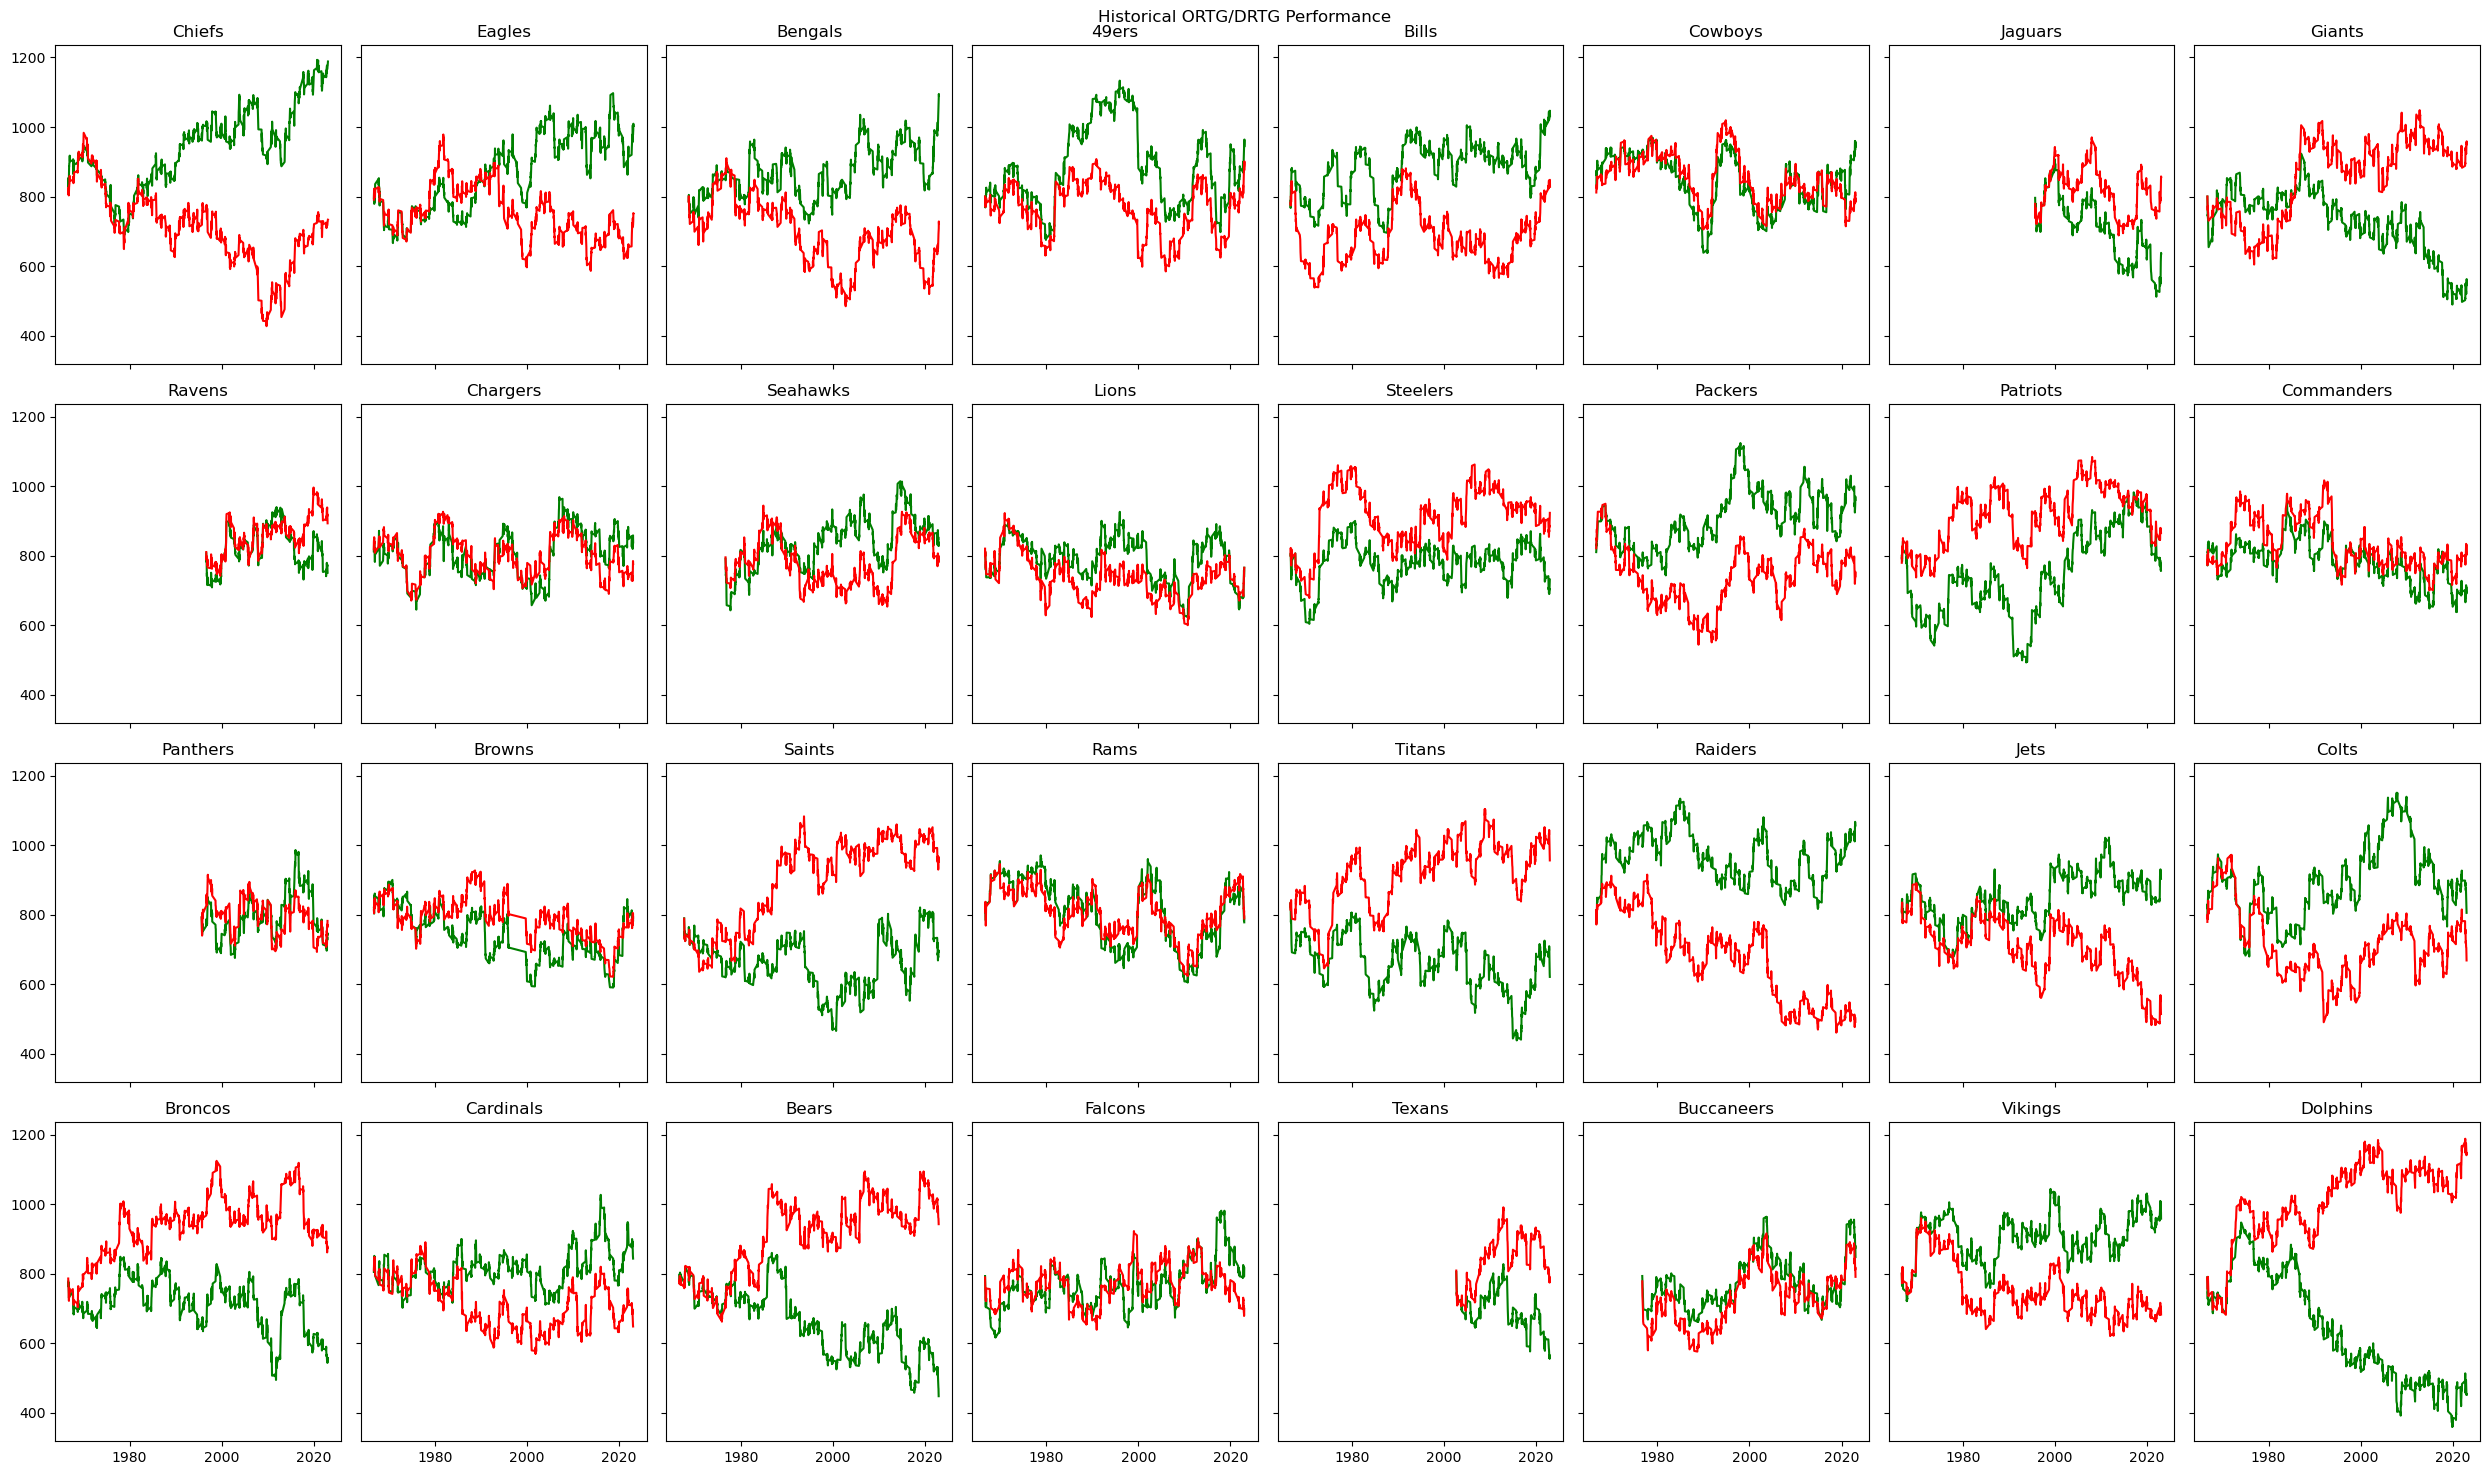

In [7]:
fig, axes = plt.subplots(ncols=8, nrows=4, figsize=(25, 15),
                         sharex=True, sharey=True)

# team = 'Patriots'
fig.suptitle('Historical ORTG/DRTG Performance')
for team,ax in zip(ortg, axes.flat):
    dates = pd.to_datetime(df[(df['team_home'] == team) | (df['team_away'] == team)]['schedule_date']).dt.date
    ax.plot(dates, o_history[team], 'g', label='ORTG')
    ax.plot(dates, d_history[team], 'r', label='DRTG')
    ax.set_title(f"{team}")
    
    # ax.set_xticklabels(dates, rotation=90)
    locator = mdates.AutoDateLocator(minticks=4, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
fig.tight_layout()
plt.show()

In [10]:
print(ortg)
print(drtg)

{'Chiefs': 1188.4749903351935, 'Eagles': 1002.8445231257174, 'Bengals': 1089.8325406515646, '49ers': 944.984900670823, 'Bills': 1031.2179910910138, 'Cowboys': 948.3972445677572, 'Jaguars': 636.1124493146608, 'Giants': 553.5555813079585, 'Ravens': 750.5863113199276, 'Chargers': 837.7669819645148, 'Seahawks': 828.9115398314615, 'Lions': 765.0040208476768, 'Steelers': 730.9636832516867, 'Packers': 960.1154981491009, 'Patriots': 756.740834988889, 'Commanders': 707.4494253594734, 'Panthers': 744.518696283773, 'Browns': 783.108702697357, 'Saints': 693.4770475381847, 'Rams': 777.7254124480579, 'Titans': 620.7134905214957, 'Raiders': 1056.5299550085292, 'Jets': 902.8578474001858, 'Colts': 805.0380484618752, 'Broncos': 556.9508936610979, 'Cardinals': 843.2121096705006, 'Bears': 447.3045237013161, 'Falcons': 815.6523726379063, 'Texans': 562.8944444093956, 'Buccaneers': 847.6586094062635, 'Vikings': 958.0684083181131, 'Dolphins': 451.3309210585261}
{'Chiefs': 733.3933056177758, 'Eagles': 751.3421

Now all we need is to go from the ORTG & DRTG to an expected point total.

In [8]:
pred_total(ortg['Vikings'], drtg['Vikings'], ortg['Eagles'], drtg['Eagles'])

63.09204193174044

In [9]:
o = ortg['Vikings'] + ortg['Eagles']
d = drtg['Vikings'] + drtg['Eagles']

print( 42 + (o - d)/25 )

63.09204193174044
